[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nils-holmberg/socs-qmd/blob/main/jnb/lab2_nlp2.ipynb)

# load text data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [56]:
fp = "israel.csv"
df = pd.read_csv(fp, header=0)
print(df.shape)
df.head()

(82, 2)


,link,content
0,https://www.economist.com/middle-east-and-afri...,WITH THE war in Gaza about to enter its third ...
1,https://www.economist.com/leaders/2023/12/07/i...,IF YOU WANT to understand how desperately Isra...
2,https://www.economist.com/middle-east-and-afri...,ON DECEMBER 1st Israel embarked on what could ...
3,https://www.economist.com/middle-east-and-afri...,WHEN HAMAS smashed across the Gaza border on O...
4,https://www.economist.com/middle-east-and-afri...,The war in Gaza has ushered in a grim new econ...


In [57]:
# Convert to list
corpus = df['content'].tolist()
corpus[:5]


['WITH THE war in Gaza about to enter its third month, Israeli forces are pushing hard into the crowded southern half of the coastal strip. In the most intense fighting seen so far, they are hoping to inflict as much damage as they can to Hamas’s remaining strongholds before the political clock runs out on what may be Israel’s last large-scale ground offensive of the war. Read all our coverage of the war between Israel and Hamas On December 5th Lieutenant-General Herzi Halevi, the chief of staff of the Israel Defence Forces (IDF), said his troops had encircled Khan Younis, the largest city in southern Gaza and the birthplace of Hamas’s two main leaders in Gaza, Yahya Sinwar and Muhammad Deif. They have since entered the city itself which, along with two other Hamas strongholds in northern Gaza, Shujaiya and Jabalia in Gaza city, have been the main focus of the IDF since the collapse of a weeklong truce on December 1st. Israel’s aim is to destroy Hamas’s military capability and its abil

In [58]:
# Download necessary NLTK data
import nltk #text cleaning packages #usual to use this word stopwords and lematization
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [59]:
# define data cleaning function
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
exclude.update("’","“","”","—") #extra weird versions of punctuation
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch if ch not in exclude else "" for ch in stop_free)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# clean data stored in a new list
clean_corpus = [clean(doc).split() for doc in corpus]

In [61]:
# Create a frequency table
word_freq = [article for article in clean_corpus]
word_freq = pd.Series(np.concatenate(word_freq)).value_counts()
# Converting the Series to a DataFrame

word_freq_df = word_freq.to_frame().reset_index()
word_freq_df.columns = ['term','freq']
word_freq_df.head()

,term,freq
0,israel,1312
1,hamas,782
2,gaza,678
3,israeli,576
4,palestinian,468


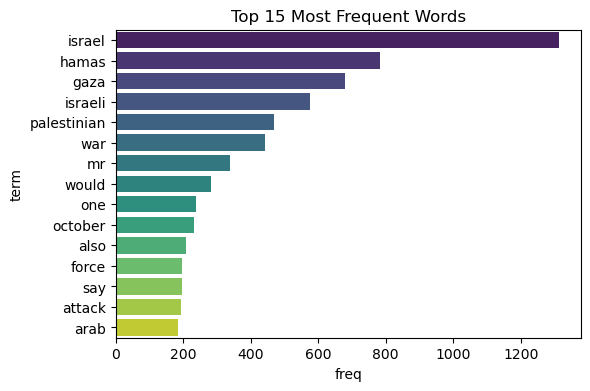

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the top N words
top_n = 15  # You can change this number to display more or fewer words
plt.figure(figsize=(6, 4))
sns.barplot(x='freq', y='term', data=word_freq_df.head(top_n), palette='viridis')

plt.title(f'Top {top_n} Most Frequent Words')
plt.xlabel('freq')
plt.ylabel('term')

plt.show()

# topic modeling

# topic modeling optimization (gensim)

In [71]:
import gensim
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt

# Assume 'documents' is a list of strings (your dataset)
# Preprocess your data here: tokenize, remove stopwords, etc.

# Create a dictionary and corpus
dictionary = Dictionary(clean_corpus)
corpus = [dictionary.doc2bow(doc) for doc in clean_corpus]

# Function to train LDA and compute both c_v and UMass coherence scores
def compute_coherence(dictionary, corpus, texts, limit, start=2, step=3):
    cv_coherence_values = []
    umass_coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        # c_v coherence
        cv_coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        cv_coherence_values.append(cv_coherencemodel.get_coherence())
        # UMass coherence
        umass_coherencemodel = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        umass_coherence_values.append(umass_coherencemodel.get_coherence())

    return model_list, cv_coherence_values, umass_coherence_values


# Set parameters and compute coherence
start, limit, step = 2, 20, 1
model_list, cv_coherence_values, umass_coherence_values = compute_coherence(dictionary=dictionary, corpus=corpus, texts=clean_corpus, start=start, limit=limit, step=step)


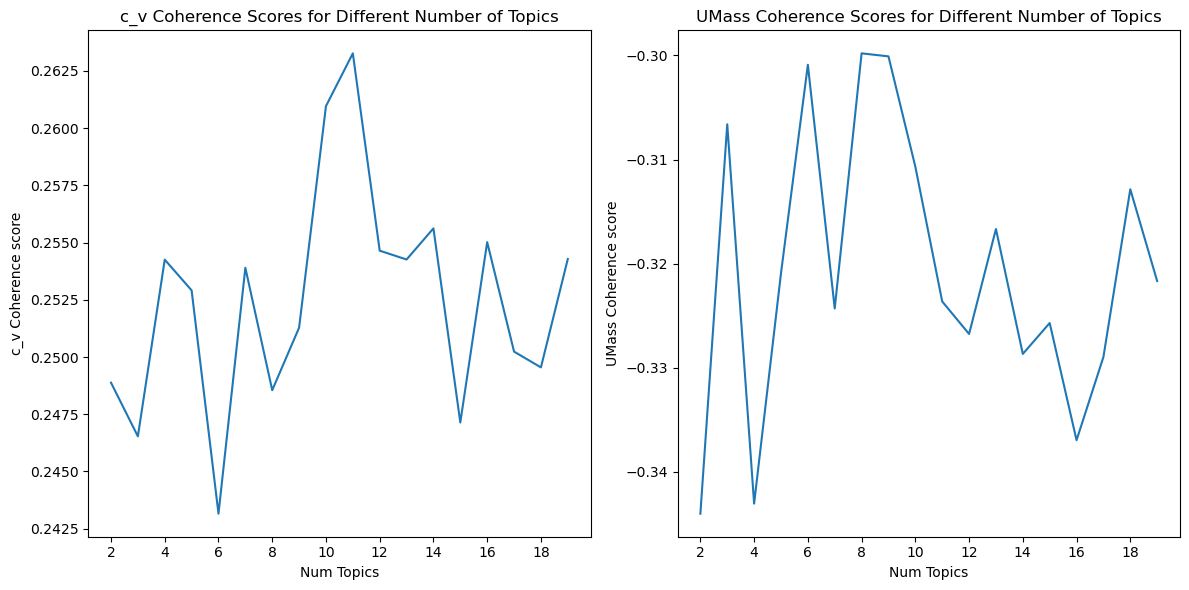

In [72]:
from matplotlib.ticker import MaxNLocator
# Plotting for c_v coherence
x = range(start, limit, step)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(x, cv_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("c_v Coherence score")
plt.title("c_v Coherence Scores for Different Number of Topics")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting for UMass coherence
plt.subplot(1, 2, 2)
plt.plot(x, umass_coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("UMass Coherence score")
plt.title("UMass Coherence Scores for Different Number of Topics")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

10 scores the best on c_V coherence. Since c_V coherence considers the context it is typically seen as a better measure so I will go with 10 topics.

In [80]:
# modeling with optimal number of topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, iterations=50, passes=10, random_state=100)


In [74]:
# Print topics
lda_model.print_topics(-1)

[(0,
  '0.022*"israel" + 0.018*"hamas" + 0.015*"gaza" + 0.011*"palestinian" + 0.008*"israeli" + 0.007*"war" + 0.006*"pa" + 0.006*"mr" + 0.006*"bank" + 0.006*"west"'),
 (1,
  '0.000*"gaza" + 0.000*"hamas" + 0.000*"israeli" + 0.000*"israel" + 0.000*"palestinian" + 0.000*"would" + 0.000*"war" + 0.000*"mr" + 0.000*"even" + 0.000*"october"'),
 (2,
  '0.018*"israel" + 0.014*"palestinian" + 0.008*"war" + 0.008*"mr" + 0.008*"arab" + 0.007*"israeli" + 0.006*"country" + 0.006*"gaza" + 0.006*"would" + 0.004*"government"'),
 (3,
  '0.013*"israel" + 0.010*"civilian" + 0.007*"attack" + 0.007*"iron" + 0.007*"israeli" + 0.006*"hamas" + 0.006*"even" + 0.006*"war" + 0.006*"beam" + 0.006*"law"'),
 (4,
  '0.013*"israel" + 0.008*"hamas" + 0.006*"gaza" + 0.006*"war" + 0.005*"israeli" + 0.005*"many" + 0.004*"october" + 0.004*"arab" + 0.004*"attack" + 0.004*"share"'),
 (5,
  '0.023*"israel" + 0.012*"gaza" + 0.011*"hamas" + 0.010*"israeli" + 0.010*"mr" + 0.008*"war" + 0.007*"would" + 0.005*"netanyahu" + 0.005*

# topic modeling visualization (gensim)

In [81]:
# fix dependency
!pip install --upgrade pandas
# topic modeling plotting tools
!pip install -q pyLDAvis
import pyLDAvis
import pyLDAvis.gensim as gensimvis

In [83]:
pyLDAvis.enable_notebook()
print(corpus)
lda_display = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display) 


TypeError: DataFrame.stack() got an unexpected keyword argument 'future_stack'

In [78]:
import sys
print(sys.version)


3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]


In [ ]:
# Save the report
pyLDAvis.save_html(vis, 'lab2-nlp2-topics.html')

# topic modelling with gensim and pyldavis
- [https://nils-holmberg.github.io/cca-nlp/jnb/scom-gpols-topics.html](https://nils-holmberg.github.io/cca-nlp/jnb/scom-gpols-topics.html)